# General import dependencies

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset Loading and Initial Analysis

https://www.kaggle.com/datasets/fedesoriano/air-quality-data-set/data

In [3]:
path = "."
filename_read = os.path.join(path, "AirQuality.csv")
dataset = pd.read_csv(filename_read, sep = ";", decimal = ",")
dataset.replace(to_replace = -200, value = np.nan, inplace = True) # -200 equal to NaN in dataset

print("Quick overview of what the data is like")
print(dataset.head())
print("Quick overview of the dataset size and types")
print(dataset.info())
print("Dataset shape")
print(dataset.shape)
print("Checking for null elements:")
print(dataset.isnull().sum(axis = 0))

Quick overview of what the data is like
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578     

# NaN values cleaning

In [4]:
dataset.drop(['NMHC(GT)','Unnamed: 15', 'Unnamed: 16'], axis = 1,inplace=True, errors = 'ignore')
# Test performance change by dropping NA values or filling them with average of their column
dataset.dropna(inplace=True)
print("Checking for null elements:")
print(dataset.isnull().sum(axis = 0))
# fill_mean = lambda col : col.fillna(col.mean())
# dataset.apply(fill_mean, axis = 0)
print(dataset.info())
print("Quick overview of dataset statistics")
print(dataset.describe())

Checking for null elements:
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 6941 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           6941 non-null   object 
 1   Time           6941 non-null   object 
 2   CO(GT)         6941 non-null   float64
 3   PT08.S1(CO)    6941 non-null   float64
 4   C6H6(GT)       6941 non-null   float64
 5   PT08.S2(NMHC)  6941 non-null   float64
 6   NOx(GT)        6941 non-null   float64
 7   PT08.S3(NOx)   6941 non-null   float64
 8   NO2(GT)        6941 non-null   float64
 9   PT08.S4(NO2)   6941 non-null   float64
 10  PT08.S5(O3)    6941 non-null   float64
 11  T             

# Date split into Day, Month, Year, Weekday, Hour (Time)

In [5]:
dataset['DateTime'] = pd.to_datetime(dataset['Date'].astype(str) + '-' + dataset['Time'].astype(str), format='%d/%m/%Y-%H.%M.%S')
dataset["Day"] = dataset["DateTime"].dt.day
dataset["Month"] = dataset["DateTime"].dt.month
dataset["Year"] = dataset["DateTime"].dt.year
dataset["Weekday"] = dataset["DateTime"].dt.day_name().astype('category').cat.codes
dataset['Time'] = dataset["DateTime"].dt.hour # Corresponds to Hour
# Drop Date as now irrelevant
dataset.drop('Date', axis = 1,inplace=True, errors = 'ignore')
time_series = dataset['DateTime']
#dataset.drop('DateTime', axis = 1,inplace=True, errors = 'ignore')
print(time_series[:3])
print(dataset.info())

print(dataset.describe())
print(dataset.head())
print(dataset[:3])


0   2004-03-10 18:00:00
1   2004-03-10 19:00:00
2   2004-03-10 20:00:00
Name: DateTime, dtype: datetime64[ns]
<class 'pandas.core.frame.DataFrame'>
Index: 6941 entries, 0 to 9356
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           6941 non-null   int32         
 1   CO(GT)         6941 non-null   float64       
 2   PT08.S1(CO)    6941 non-null   float64       
 3   C6H6(GT)       6941 non-null   float64       
 4   PT08.S2(NMHC)  6941 non-null   float64       
 5   NOx(GT)        6941 non-null   float64       
 6   PT08.S3(NOx)   6941 non-null   float64       
 7   NO2(GT)        6941 non-null   float64       
 8   PT08.S4(NO2)   6941 non-null   float64       
 9   PT08.S5(O3)    6941 non-null   float64       
 10  T              6941 non-null   float64       
 11  RH             6941 non-null   float64       
 12  AH             6941 non-null   float64       
 13  DateTime       694

# Time Series Analysis:
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [6]:
dataset = dataset.set_index('DateTime')
dataset.head(3)
print(dataset.index)
print(dataset.index.min(), dataset.index.max())
print(dataset['Month'].min(), dataset['Month'].max())

DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 05:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=6941, freq=None)
2004-03-10 18:00:00 2005-04-04 14:00:00
1 12


## Check Distribution of Time after Cleaning of Data

2004-03-10 18:00:00 2004-12-28 00:00:00


<Axes: xlabel='Month', ylabel='Count'>

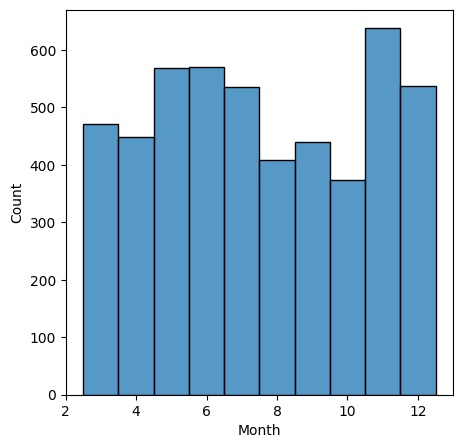

In [7]:
temp = dataset.loc['2004']
print(temp.index.min(), temp.index.max())
# print(temp)
# print(temp['Month'].min(), temp['Month'].max())
plt.figure(figsize=(5,5))
sns.histplot(data=temp, x='Month', bins = 10, discrete = True)

2005-01-01 01:00:00 2005-04-04 14:00:00


<Axes: xlabel='Month', ylabel='Count'>

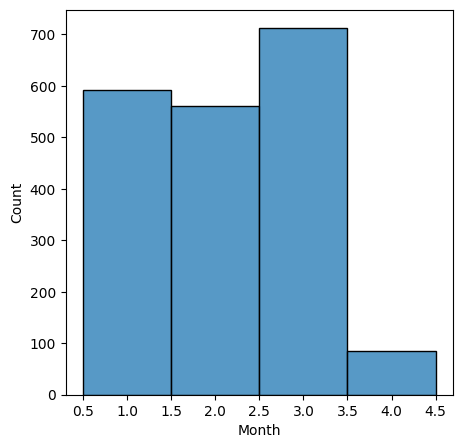

In [8]:
temp = dataset.loc['2005']
print(temp.index.min(), temp.index.max())
plt.figure(figsize=(5,5))
sns.histplot(data=temp, x='Month', bins = 4, discrete = True)

## Most Important Gases dataset analysis

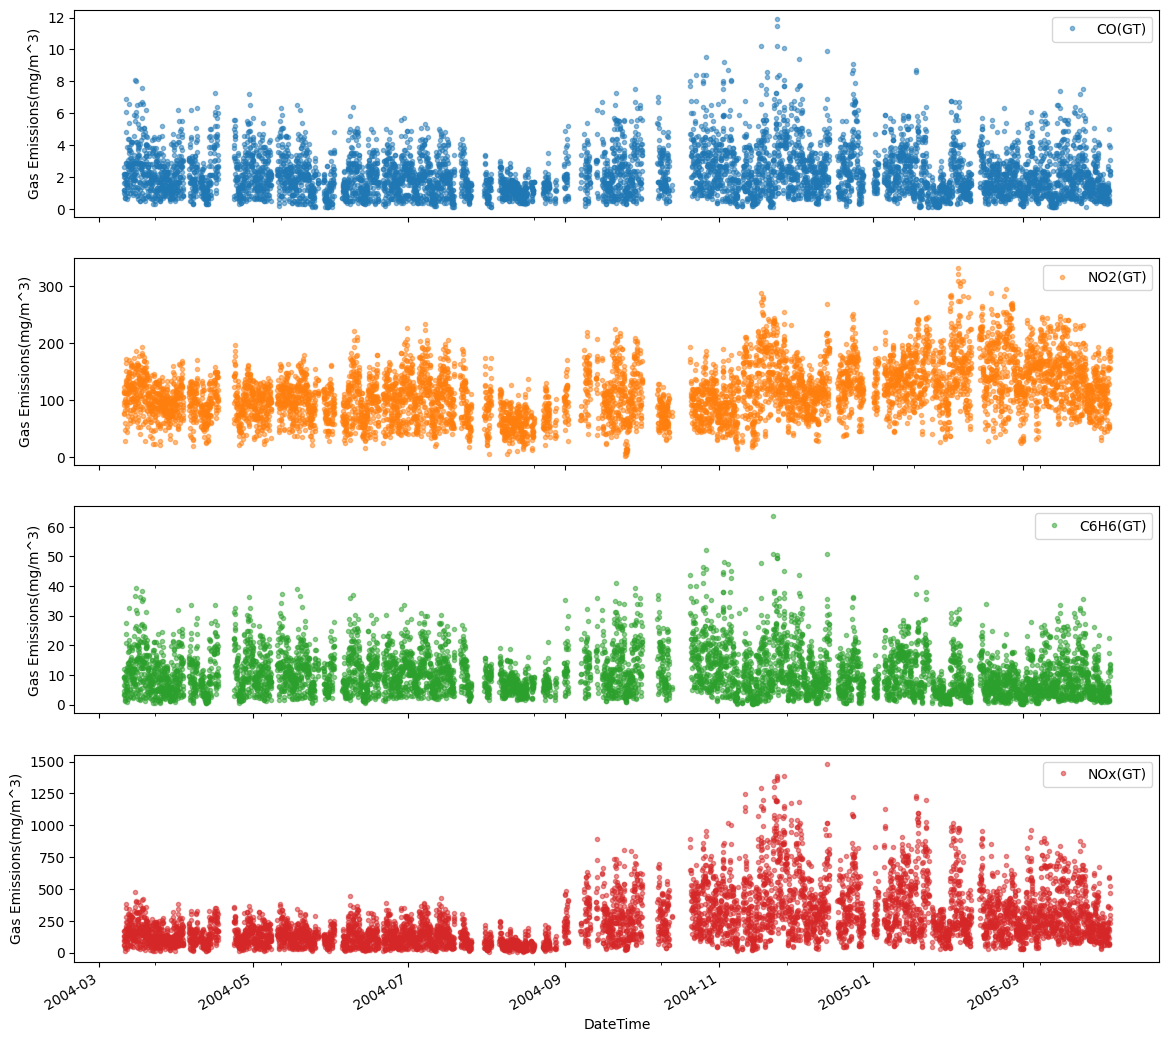

In [11]:
col_plot = ['CO(GT)', 'NO2(GT)','C6H6(GT)', 'NOx(GT)']
axes = dataset[col_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(14, 14), subplots=True)
for ax in axes:
    ax.set_ylabel('Gas Emissions(mg/m^3)')

## Temperature and Humidity Dataset Analysis 

Text(0, 0.5, 'Daily Temperature in Celsius')

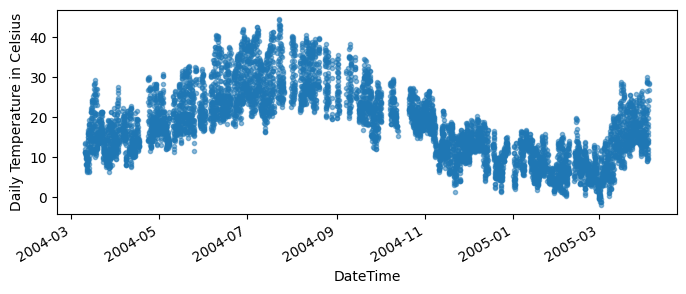

In [12]:
ax = dataset['T'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(8, 3))
ax.set_ylabel('Daily Temperature in Celsius')

Text(0, 0.5, 'Daily Absolute Humidity')

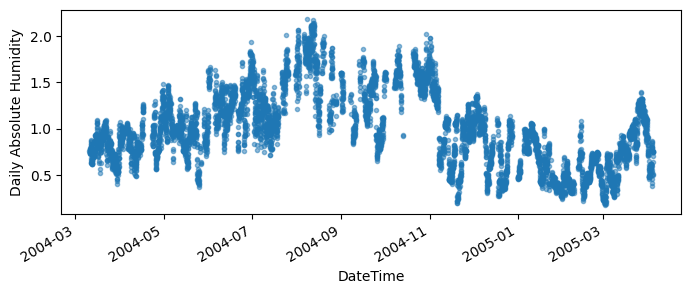

In [14]:
ax = dataset['AH'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(8, 3))
ax.set_ylabel('Daily Absolute Humidity')

Text(0, 0.5, 'Daily Relative Humidity')

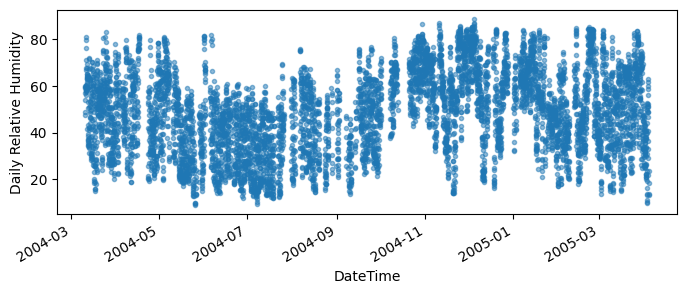

In [15]:
ax = dataset['RH'].plot(marker='.', alpha=0.5, linestyle='None', figsize=(8, 3))
ax.set_ylabel('Daily Relative Humidity')

## Daily Analysis

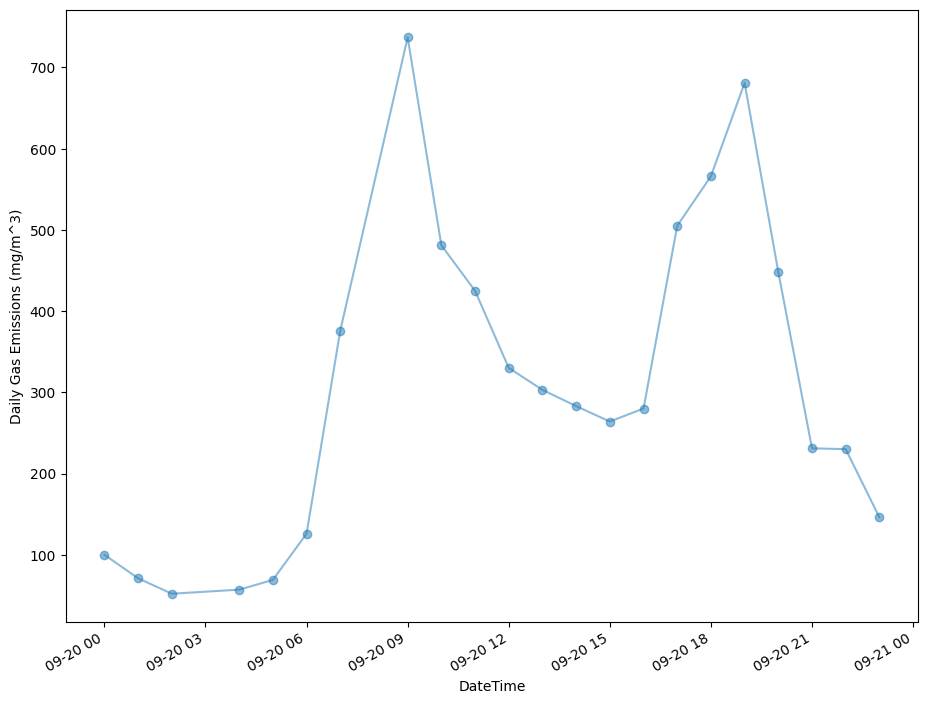

In [16]:
ax = dataset.loc['2004-09-20', 'NOx(GT)'].plot(marker='o', linestyle='-', alpha=0.5, figsize=(11, 9))
ax.set_ylabel('Daily Gas Emissions (mg/m^3)');

## Weekly Analysis

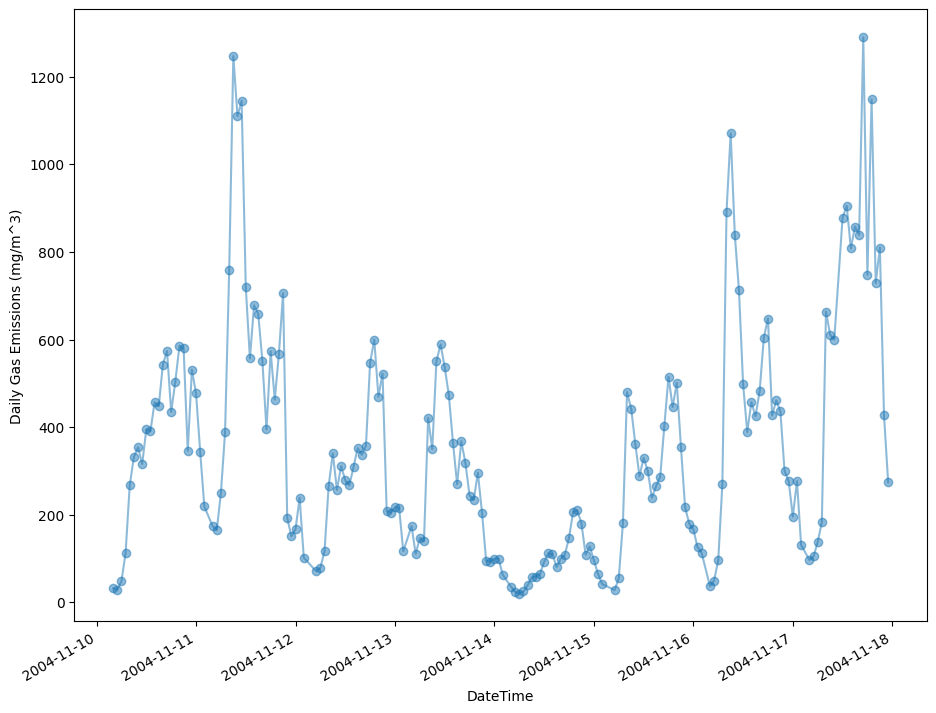

In [17]:
# Weekly Analysis
ax = dataset.loc['2004-11-10':'2004-11-17', 'NOx(GT)'].plot(marker='o', linestyle='-', alpha=0.5, figsize=(11, 9))
ax.set_ylabel('Daily Gas Emissions (mg/m^3)');
# print(dataset.loc['2004-09-17':'2004-09-24']['Weekday'])

## Monthly Analysis

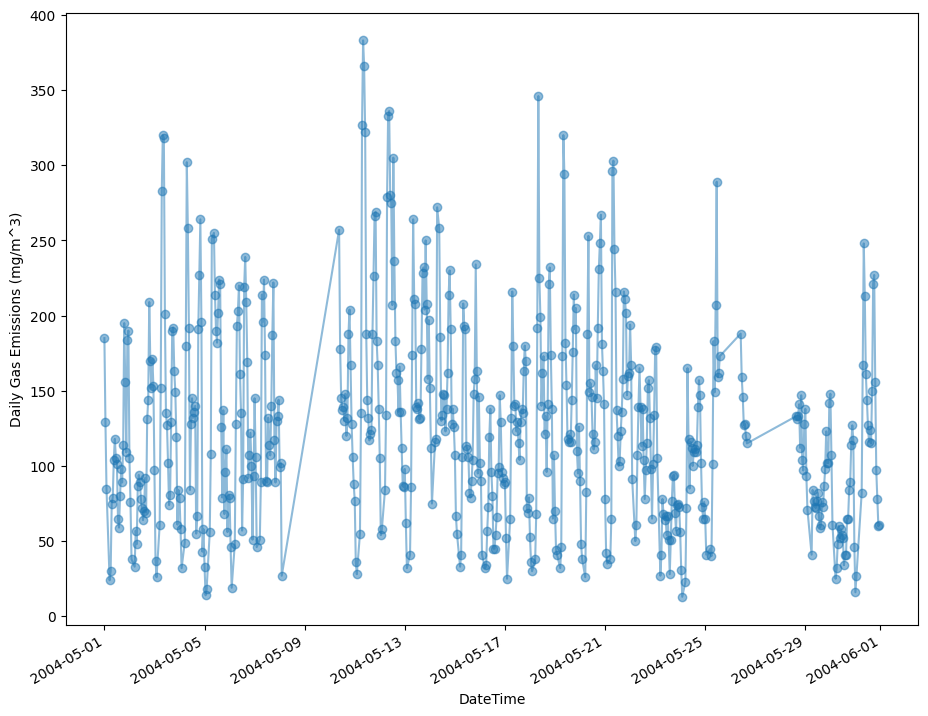

In [18]:
ax = dataset.loc['2004-05', 'NOx(GT)'].plot(marker='o', linestyle='-', alpha=0.5, figsize=(11, 9))
ax.set_ylabel('Daily Gas Emissions (mg/m^3)');

## Yearly Analysis


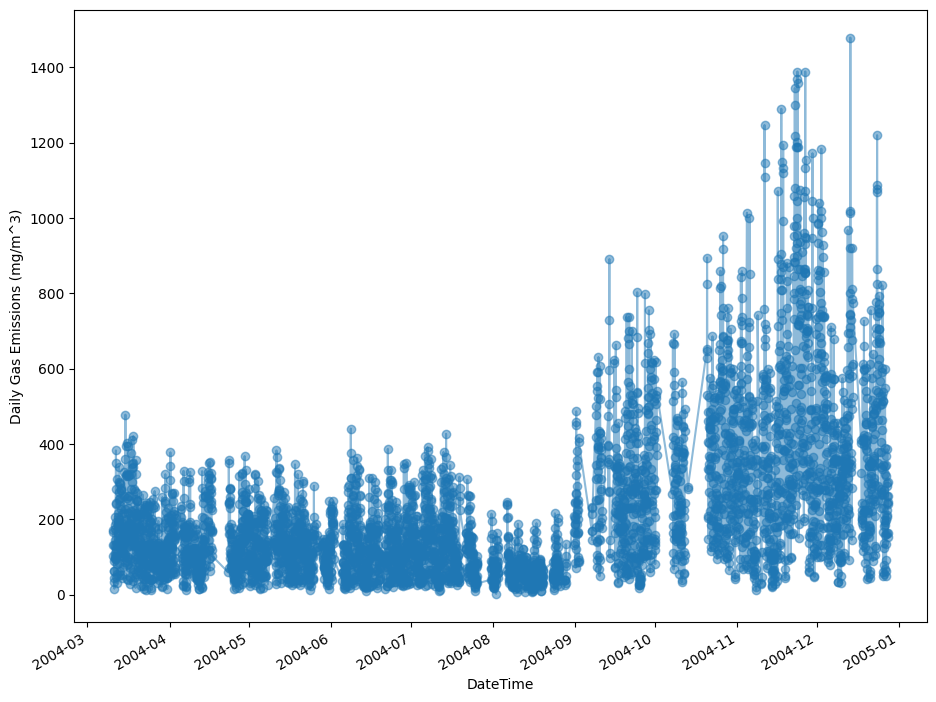

In [19]:
ax = dataset.loc['2004', 'NOx(GT)'].plot(marker='o', linestyle='-', alpha=0.5, figsize=(11, 9))
ax.set_ylabel('Daily Gas Emissions (mg/m^3)');

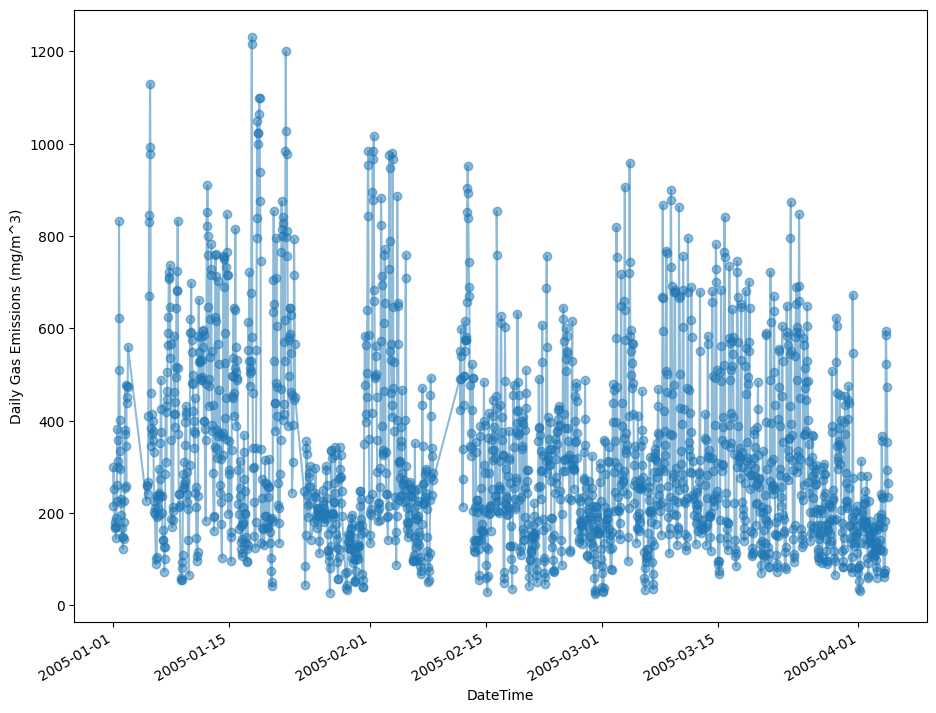

In [20]:
ax = dataset.loc['2005', 'NOx(GT)'].plot(marker='o', linestyle='-', alpha=0.5, figsize=(11, 9))
ax.set_ylabel('Daily Gas Emissions (mg/m^3)');

# Correlation Table

In [21]:
corr = dataset.corr()
corr.style.background_gradient(cmap='coolwarm')

# Feature Importance

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6941 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           6941 non-null   int32  
 1   CO(GT)         6941 non-null   float64
 2   PT08.S1(CO)    6941 non-null   float64
 3   C6H6(GT)       6941 non-null   float64
 4   PT08.S2(NMHC)  6941 non-null   float64
 5   PT08.S3(NOx)   6941 non-null   float64
 6   NO2(GT)        6941 non-null   float64
 7   PT08.S4(NO2)   6941 non-null   float64
 8   PT08.S5(O3)    6941 non-null   float64
 9   T              6941 non-null   float64
 10  RH             6941 non-null   float64
 11  AH             6941 non-null   float64
 12  Day            6941 non-null   int32  
 13  Month          6941 non-null   int32  
 14  Year           6941 non-null   int32  
 15  Weekday        6941 non-null   int8   
dtypes: float64(11), int32(4), int8(1)
memory usage: 1024.0 KB
No

Text(0.5, 0, 'Feature importances using MDI')

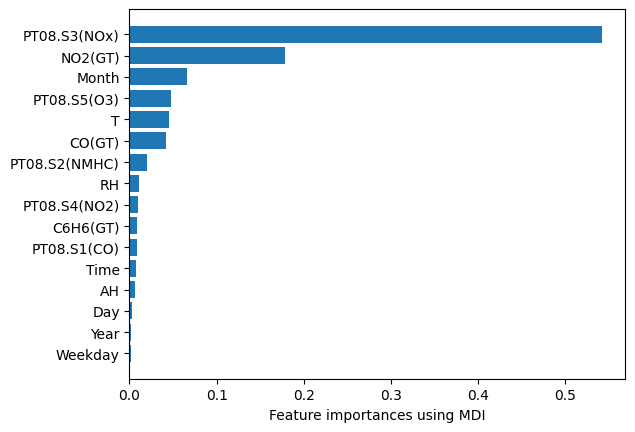

In [22]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=0, n_estimators=100)

x = dataset.drop('NOx(GT)', axis = 1)
print(x.info())
feature_names = x.columns.values
y = dataset['NOx(GT)']
forest.fit(x, y)


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

#forest_importances = pd.Series(importances, index=feature_names)
#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
##ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
sorted_idx = importances.argsort()
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature importances using MDI")


# Encode Time data

In [23]:
# Reference: https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    dataset.drop(col, axis = 1,inplace=True, errors = 'ignore')
    return data

In [24]:
dataset = encode(dataset, 'Month', dataset['Month'].max()) 
dataset = encode(dataset, 'Day', dataset['Day'].max()) 
dataset = encode(dataset, 'Weekday', dataset['Weekday'].max()) 
dataset = encode(dataset, 'Time', dataset['Time'].max())

print(dataset.info())
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6941 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         6941 non-null   float64
 1   PT08.S1(CO)    6941 non-null   float64
 2   C6H6(GT)       6941 non-null   float64
 3   PT08.S2(NMHC)  6941 non-null   float64
 4   NOx(GT)        6941 non-null   float64
 5   PT08.S3(NOx)   6941 non-null   float64
 6   NO2(GT)        6941 non-null   float64
 7   PT08.S4(NO2)   6941 non-null   float64
 8   PT08.S5(O3)    6941 non-null   float64
 9   T              6941 non-null   float64
 10  RH             6941 non-null   float64
 11  AH             6941 non-null   float64
 12  Year           6941 non-null   int32  
 13  Month_sin      6941 non-null   float64
 14  Month_cos      6941 non-null   float64
 15  Day_sin        6941 non-null   float64
 16  Day_cos        6941 non-null   float64
 17  Weekday_sin    6

# Drop Features

In [25]:
# Drop most correlated features
# How to choose which features to keep?
# Loss of performance?
#dataset.drop(['PT08.S2(NMHC)', 'PT08.S1(CO)', 'C6H6(GT)'], axis = 1,inplace=True, errors = 'ignore')
dataset.drop(['PT08.S2(NMHC)', 'PT08.S1(CO)', 'C6H6(GT)', 'CO(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'], axis = 1,inplace=True, errors = 'ignore')
# dataset.drop(['PT08.S2(NMHC)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)'], axis = 1,inplace=True, errors = 'ignore')

print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6941 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NOx(GT)      6941 non-null   float64
 1   T            6941 non-null   float64
 2   RH           6941 non-null   float64
 3   AH           6941 non-null   float64
 4   Year         6941 non-null   int32  
 5   Month_sin    6941 non-null   float64
 6   Month_cos    6941 non-null   float64
 7   Day_sin      6941 non-null   float64
 8   Day_cos      6941 non-null   float64
 9   Weekday_sin  6941 non-null   float64
 10  Weekday_cos  6941 non-null   float64
 11  Time_sin     6941 non-null   float64
 12  Time_cos     6941 non-null   float64
dtypes: float64(12), int32(1)
memory usage: 990.1 KB
None


# Pairwise Relationships

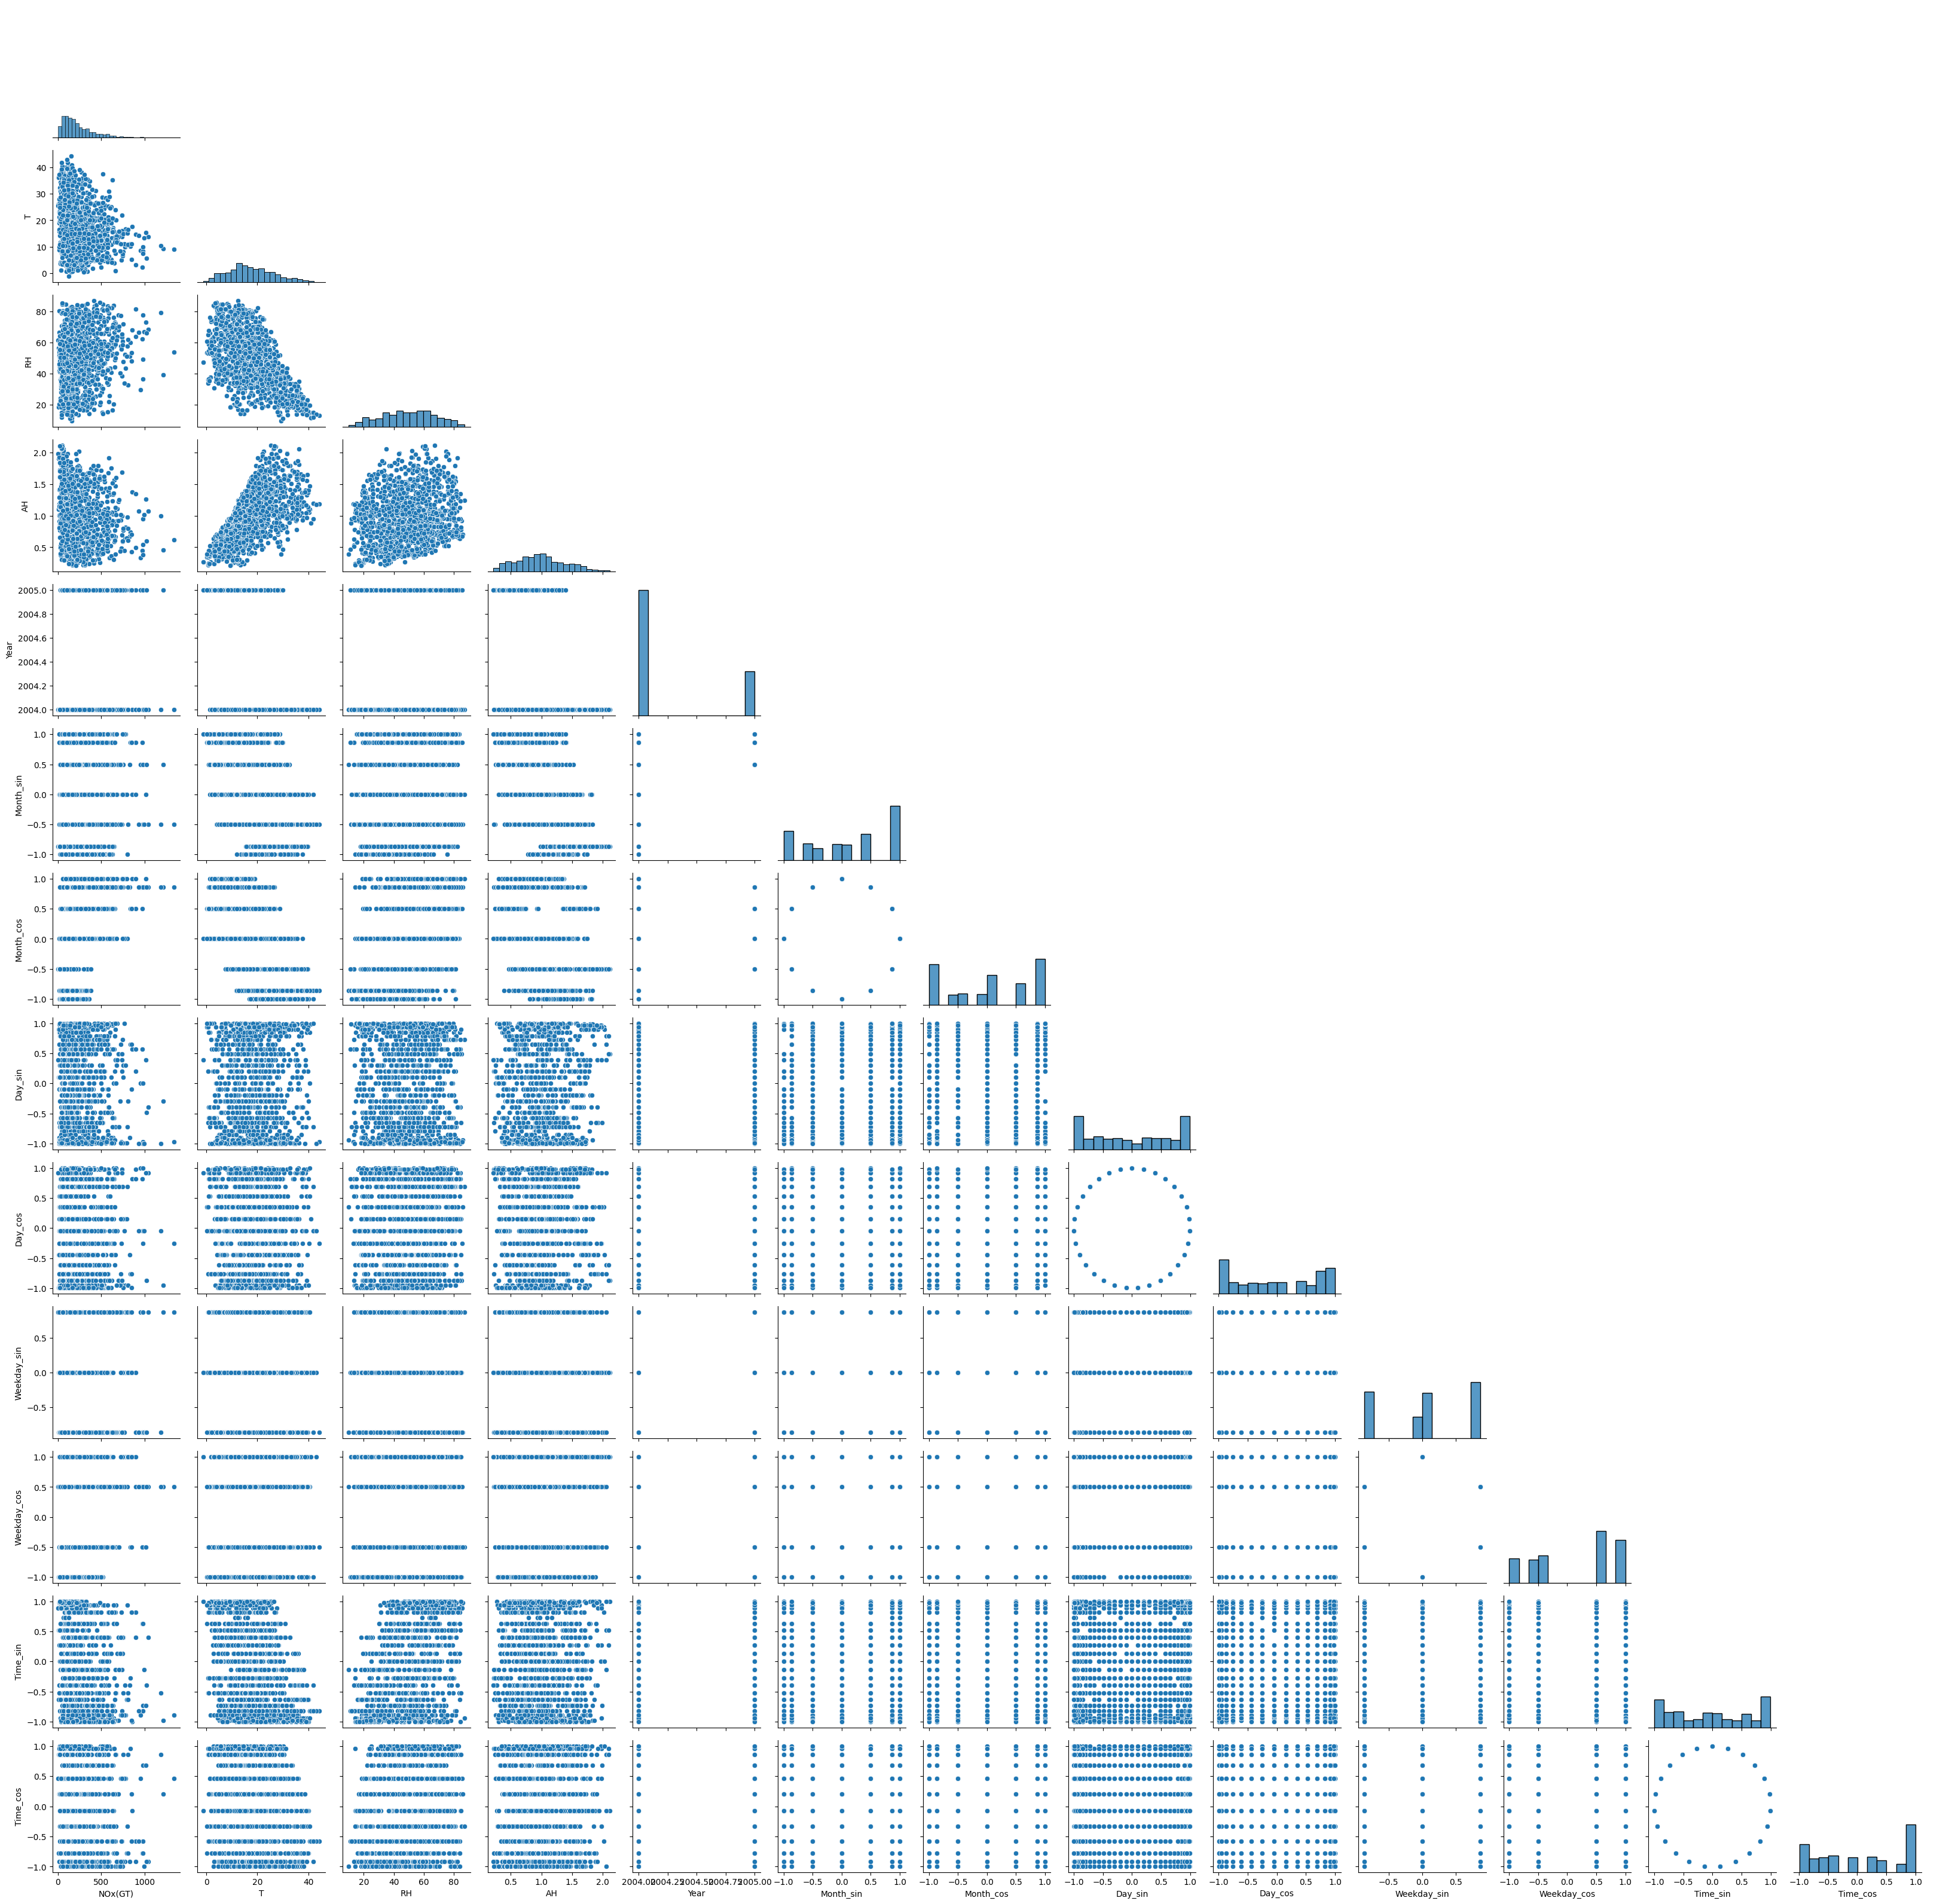

In [32]:
# import seaborn as sns

dataset_percent = dataset.sample(frac=0.2)
g = sns.PairGrid(dataset_percent,corner = True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

# Value Distribution

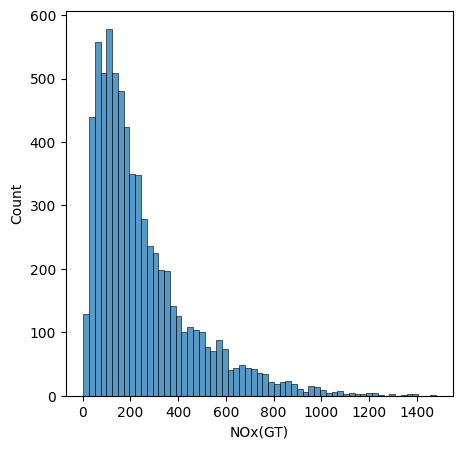

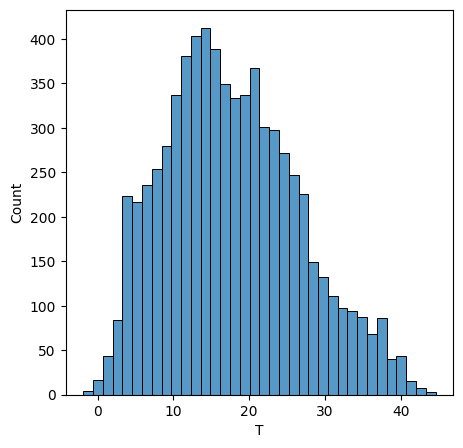

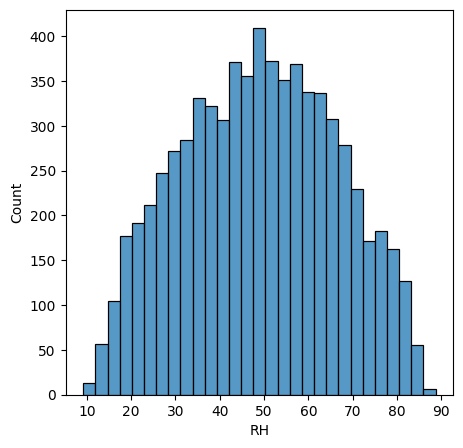

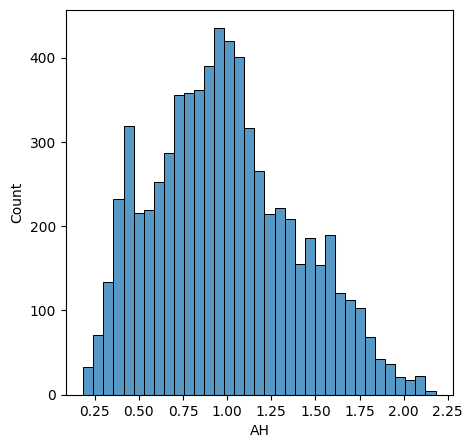

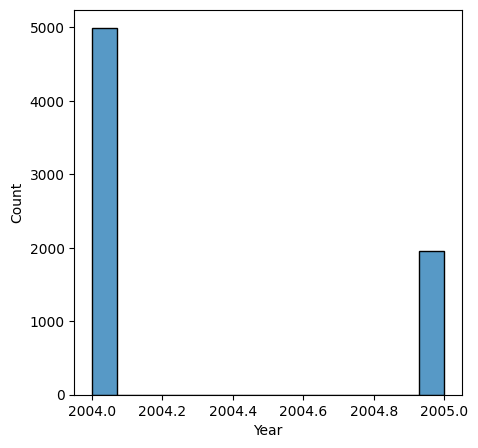

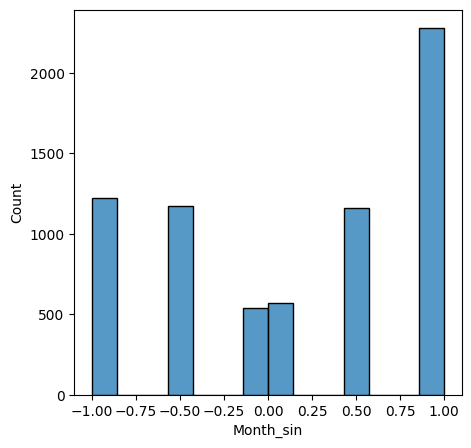

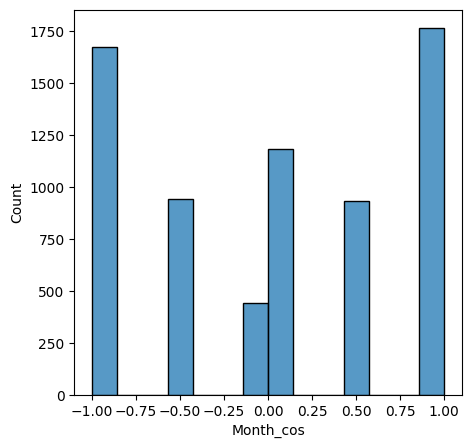

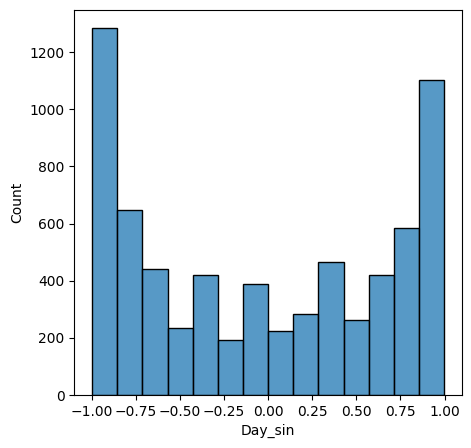

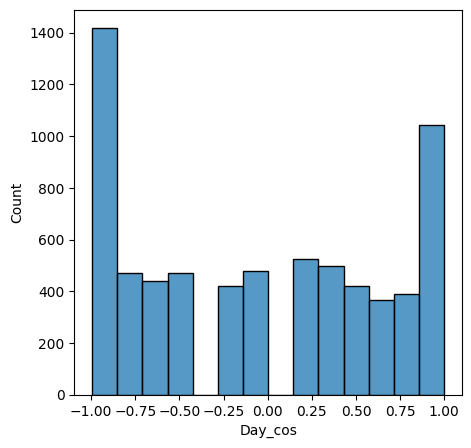

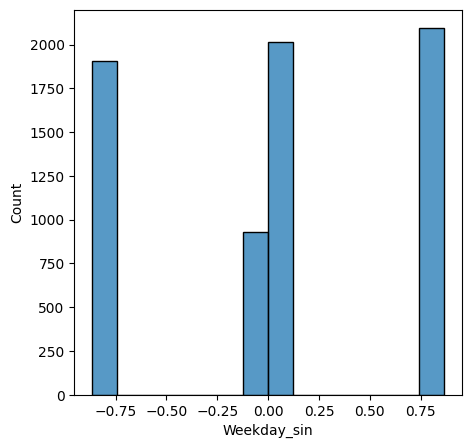

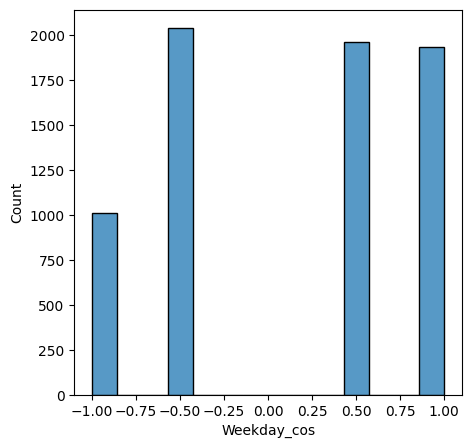

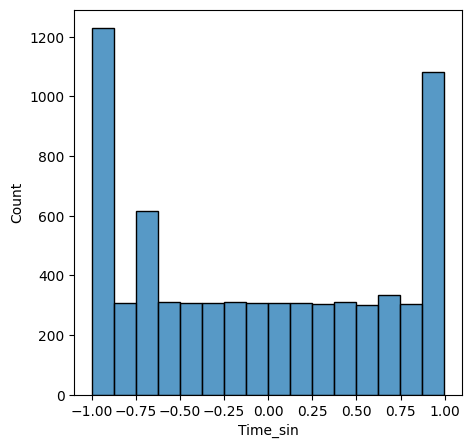

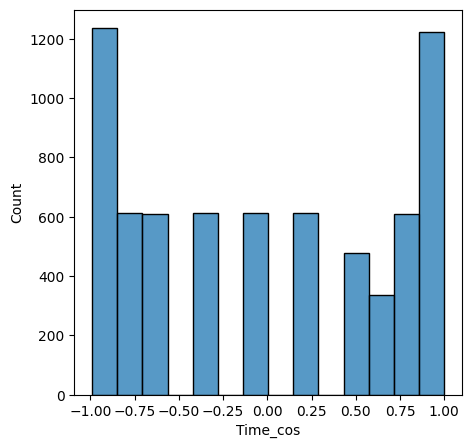

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in dataset:
    plt.figure(figsize=(5,5))
    sns.histplot(data=dataset, x=column)

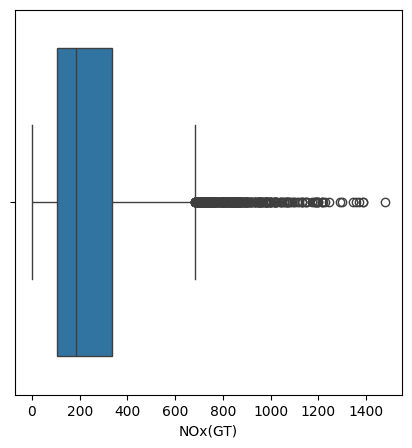

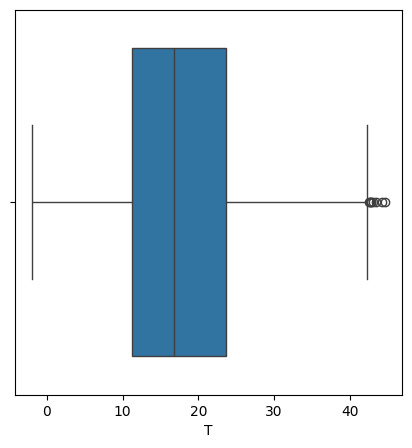

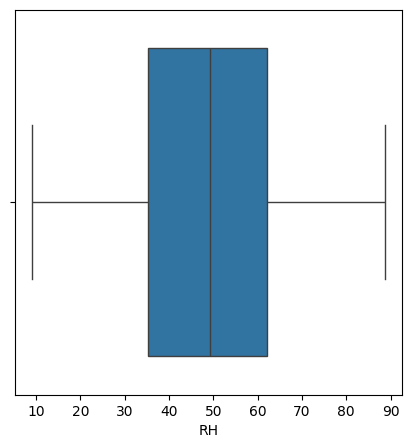

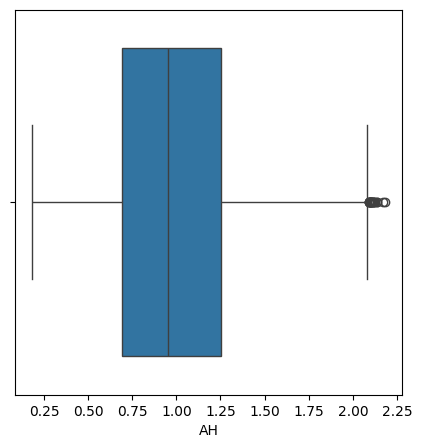

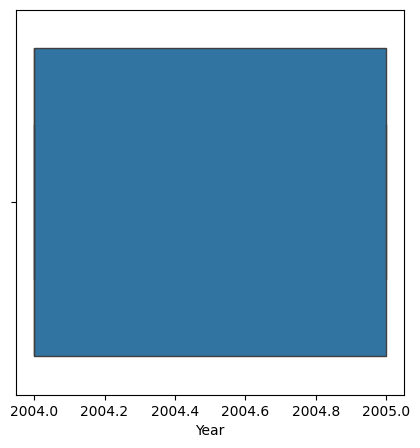

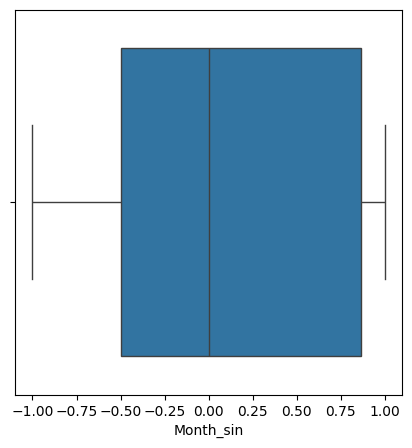

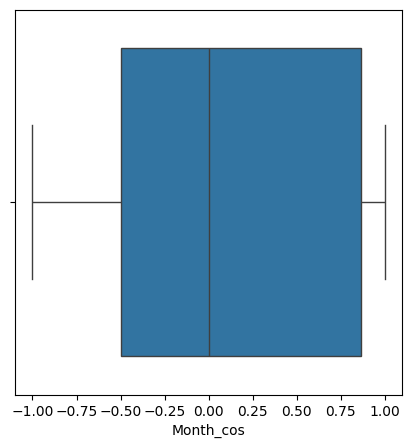

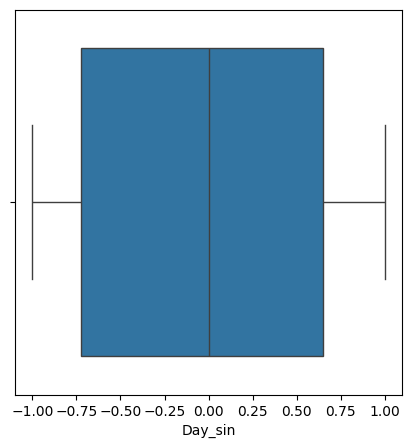

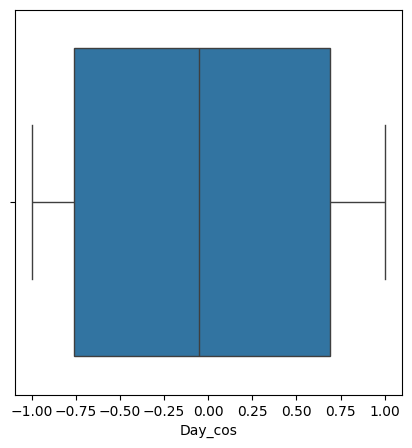

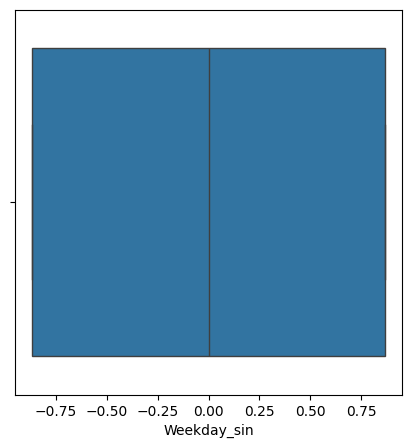

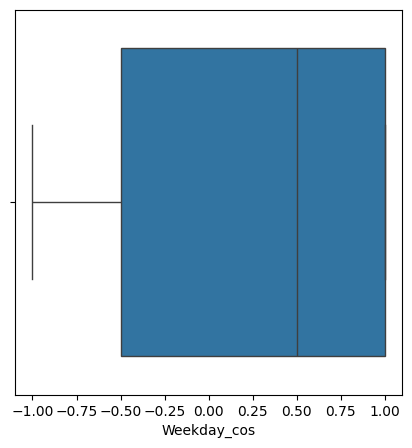

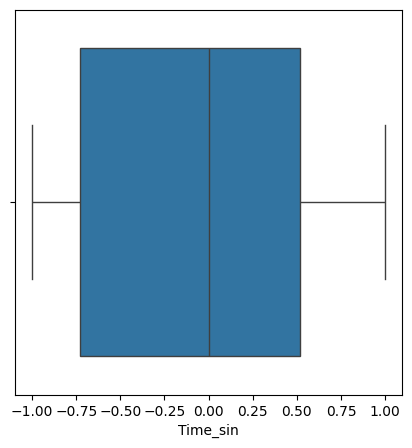

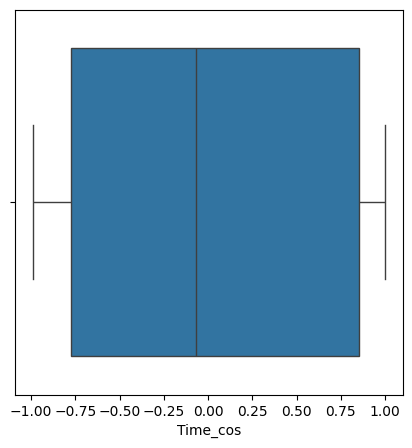

In [34]:
#  Doubts interpreting boxplot
import matplotlib.pyplot as plt

for column in dataset:
    plt.figure(figsize=(5,5))
    sns.boxplot(data=dataset, x=column)

C:\Users\julia\AppData\Local\Temp\ipykernel_29708\1222823143.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


<Figure size 500x500 with 0 Axes>

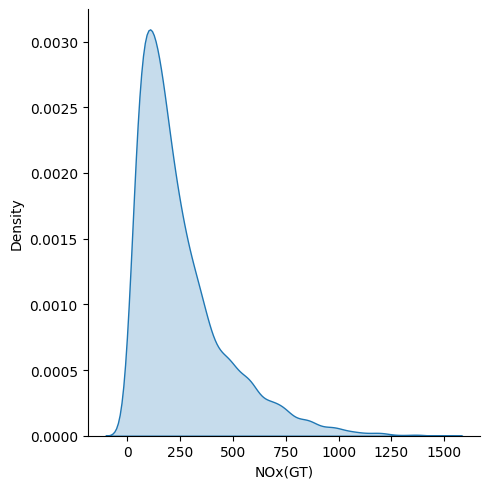

<Figure size 500x500 with 0 Axes>

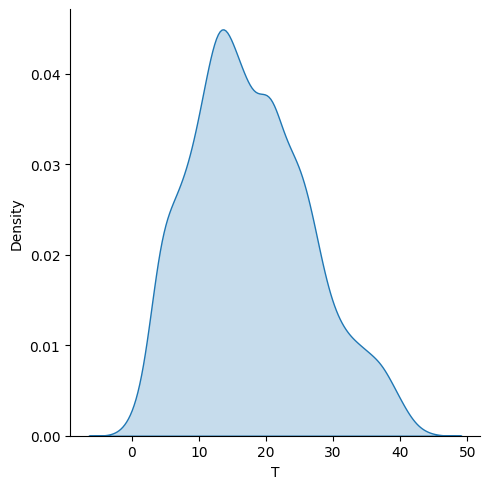

<Figure size 500x500 with 0 Axes>

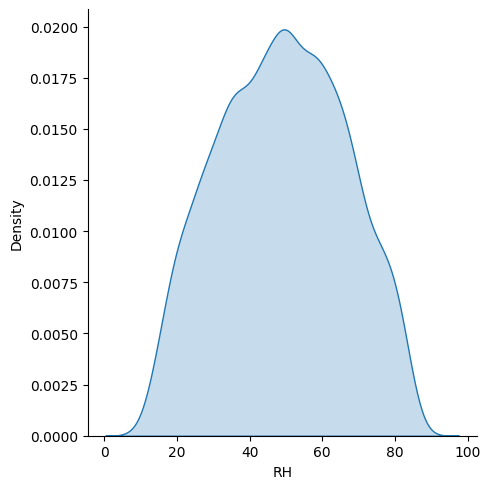

<Figure size 500x500 with 0 Axes>

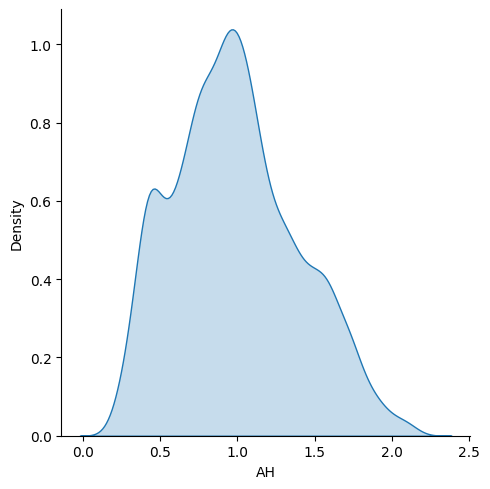

<Figure size 500x500 with 0 Axes>

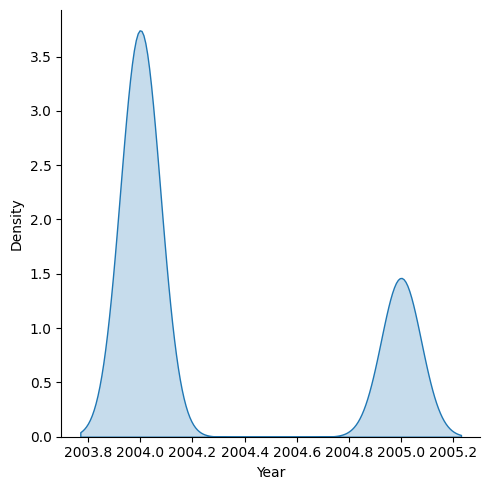

<Figure size 500x500 with 0 Axes>

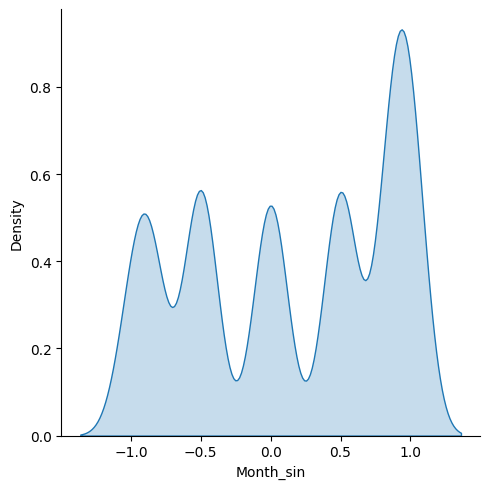

<Figure size 500x500 with 0 Axes>

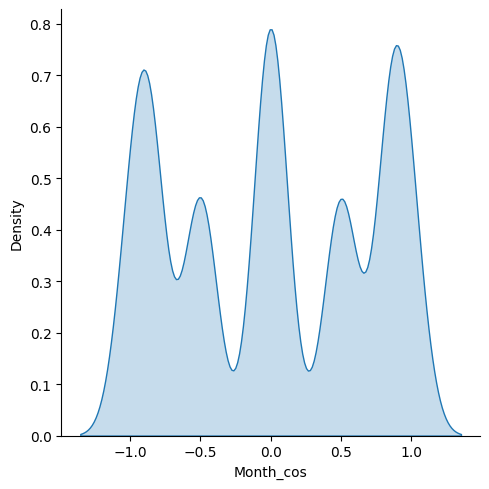

<Figure size 500x500 with 0 Axes>

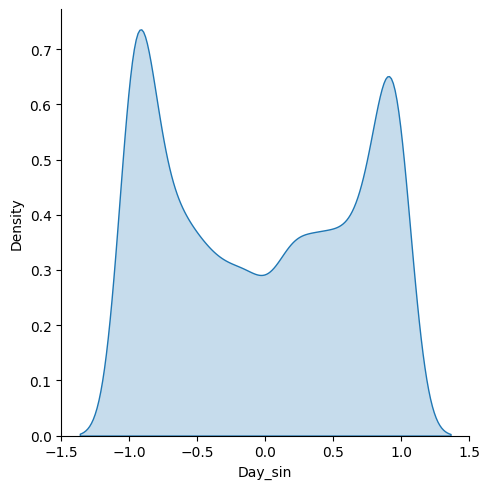

<Figure size 500x500 with 0 Axes>

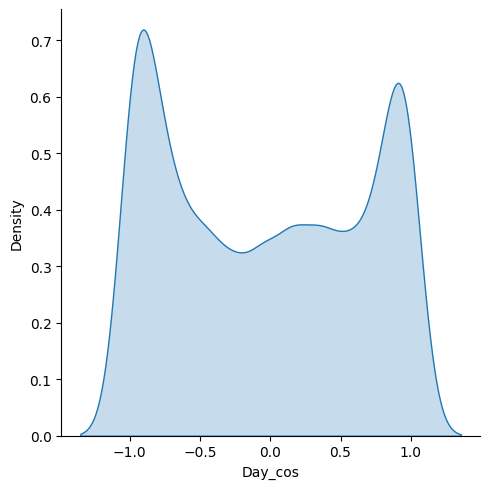

<Figure size 500x500 with 0 Axes>

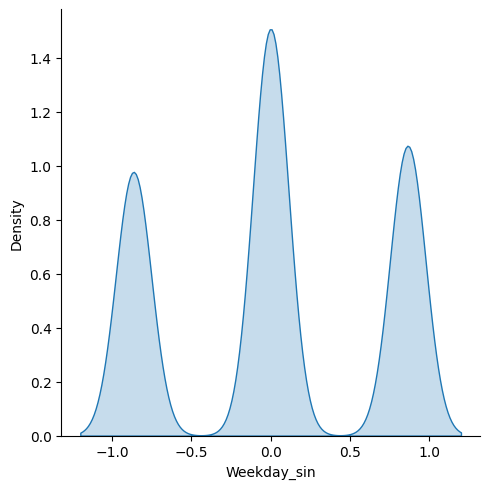

<Figure size 500x500 with 0 Axes>

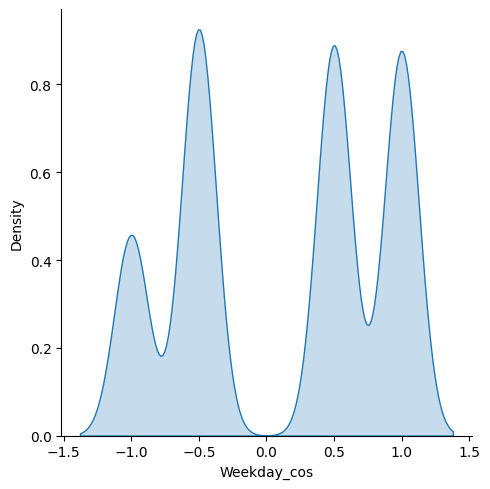

<Figure size 500x500 with 0 Axes>

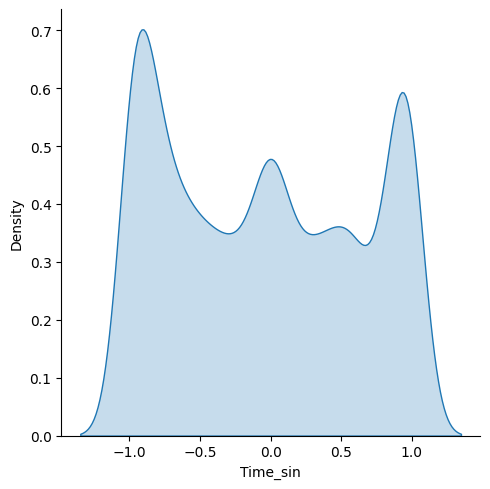

<Figure size 500x500 with 0 Axes>

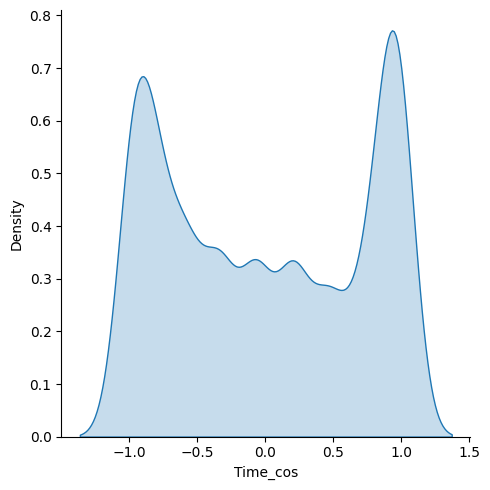

In [35]:
for column in dataset:
    plt.figure(figsize=(5,5))
    sns.displot(data=dataset, x=column, kind="kde", fill = True)

# Values skew Logarithm Solution

In [36]:
for column in dataset.iloc[:, : 4]:
    print(column)
    if column == "T":
        dataset[column] = np.log(dataset[column] + 3)
    else:
        dataset[column] = np.log(dataset[column] + 1)

NOx(GT)
T
RH
AH


<Figure size 500x500 with 0 Axes>

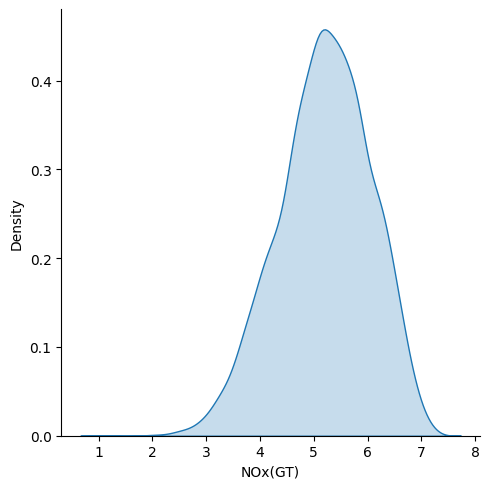

<Figure size 500x500 with 0 Axes>

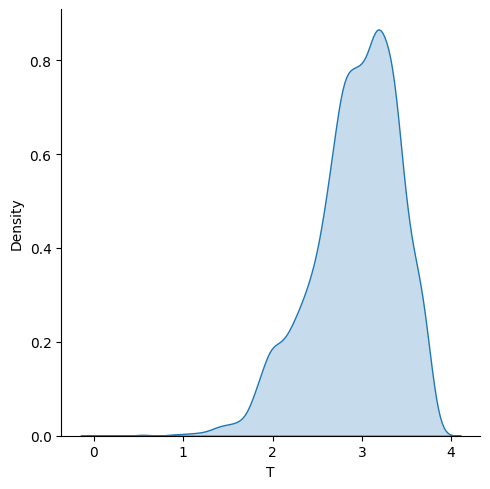

<Figure size 500x500 with 0 Axes>

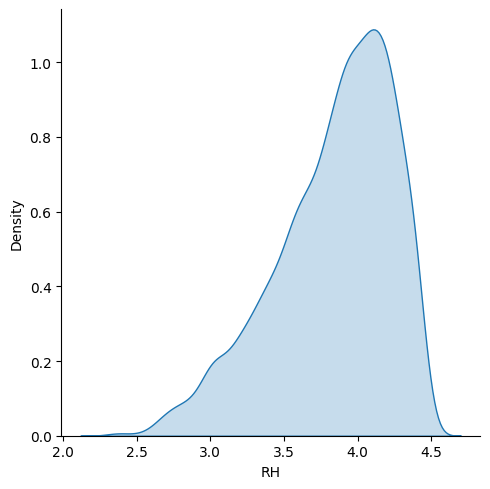

<Figure size 500x500 with 0 Axes>

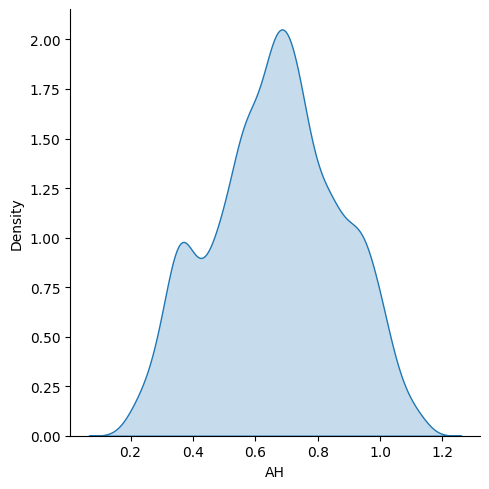

<Figure size 500x500 with 0 Axes>

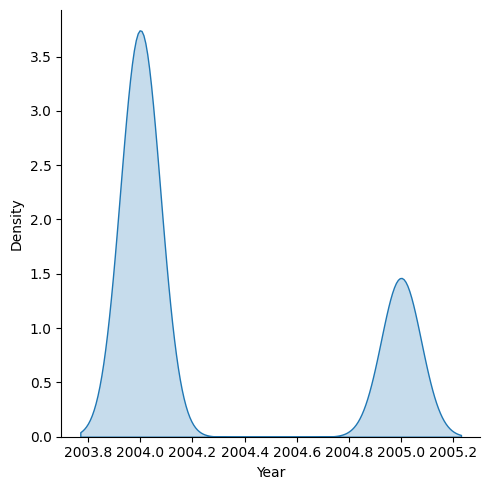

<Figure size 500x500 with 0 Axes>

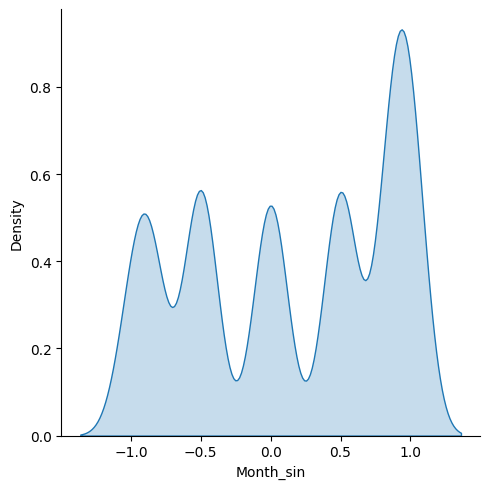

<Figure size 500x500 with 0 Axes>

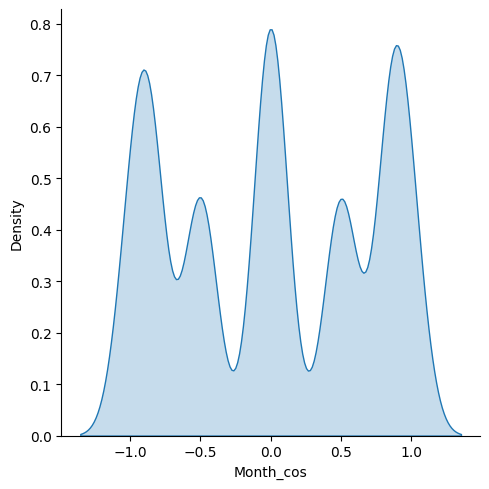

<Figure size 500x500 with 0 Axes>

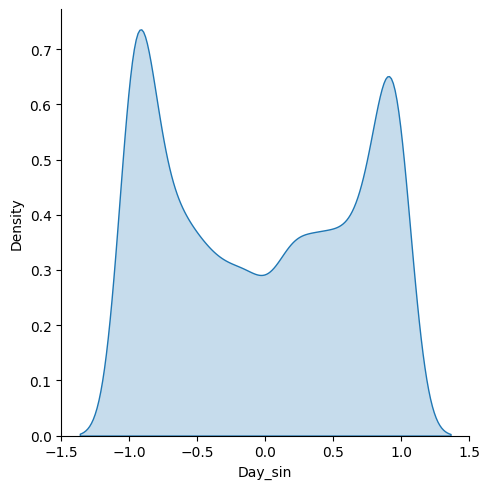

<Figure size 500x500 with 0 Axes>

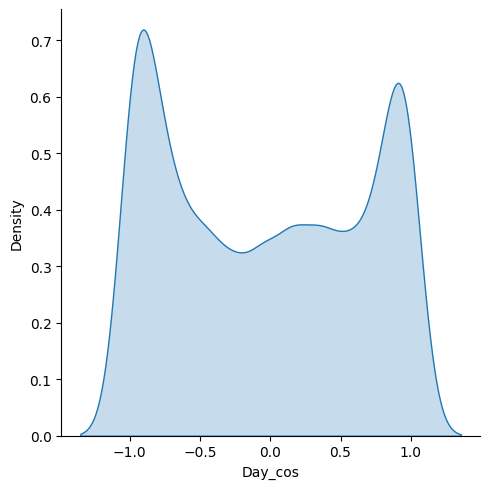

In [37]:
for column in dataset.iloc[:, : 9]:
    plt.figure(figsize=(5,5))
    sns.displot(data=dataset, x=column, kind="kde", fill = True)

# Split Labels and Values

In [60]:
y = dataset['NOx(GT)']
# Time series dataframe cannot be loaded into sklearn -> Useful for analysis
dataset_final = dataset.drop('NOx(GT)',axis=1)
print(dataset_final.info())
#dataset.drop('DateTime', axis = 1,inplace=True, errors = 'ignore')
X = dataset_final.values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6941 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T            6941 non-null   float64
 1   RH           6941 non-null   float64
 2   AH           6941 non-null   float64
 3   Year         6941 non-null   int32  
 4   Month_sin    6941 non-null   float64
 5   Month_cos    6941 non-null   float64
 6   Day_sin      6941 non-null   float64
 7   Day_cos      6941 non-null   float64
 8   Weekday_sin  6941 non-null   float64
 9   Weekday_cos  6941 non-null   float64
 10  Time_sin     6941 non-null   float64
 11  Time_cos     6941 non-null   float64
dtypes: float64(11), int32(1)
memory usage: 935.9 KB
None


# PCA

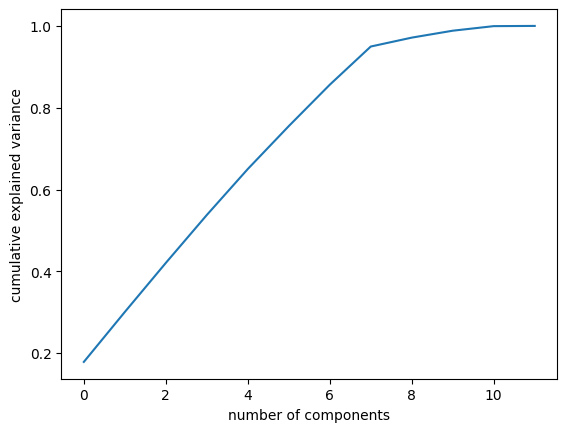

In [39]:
from sklearn.decomposition import PCA

pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [40]:
# Not used as there are limited features
pca = PCA(8)  
print(X.shape)
X = pca.fit_transform(X)
print(X.shape)

(6941, 12)
(6941, 8)


# Train and Test Split

In [61]:
from sklearn.model_selection import train_test_split

print(X.shape)
print(y.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
print(ytrain[:10])
print(ytest[:10])

#print(Xtrain[:10])
#print(Xtest[:10])

(6941, 12)
(6941,)
DateTime
2004-05-03 00:00:00    4.584967
2004-06-06 15:00:00    3.951244
2004-11-07 09:00:00    4.615121
2005-02-27 15:00:00    4.624973
2004-12-07 20:00:00    5.669881
2004-12-01 00:00:00    5.613128
2004-11-29 16:00:00    5.758902
2005-02-02 12:00:00    6.572283
2004-11-27 08:00:00    5.988961
2005-01-11 05:00:00    4.672829
Name: NOx(GT), dtype: float64
DateTime
2004-11-25 16:00:00    6.144186
2005-03-26 07:00:00    5.170484
2005-03-28 19:00:00    6.232448
2005-03-20 18:00:00    5.484797
2005-03-19 18:00:00    5.587249
2005-03-21 00:00:00    5.214936
2004-03-15 10:00:00    5.978886
2004-07-10 01:00:00    4.521789
2004-12-06 01:00:00    4.836282
2004-10-09 04:00:00    4.574711
Name: NOx(GT), dtype: float64


# Time Series Split

(5931,)
(201,)
<bound method DataFrame.info of                             T        RH        AH  Year  Month_sin  \
DateTime                                                             
2004-03-11 08:00:00  2.624669  4.067316  0.554345  2004   1.000000   
2004-03-11 09:00:00  2.602690  4.120662  0.570471  2004   1.000000   
2004-03-11 10:00:00  2.624669  4.084294  0.562583  2004   1.000000   
2004-03-11 11:00:00  2.602690  4.075841  0.551123  2004   1.000000   
2004-03-11 12:00:00  2.525729  4.216562  0.585061  2004   1.000000   
...                       ...       ...       ...   ...        ...   
2005-02-28 19:00:00  1.526056  3.660994  0.234677  2005   0.866025   
2005-02-28 20:00:00  1.481605  3.663562  0.232301  2005   0.866025   
2005-02-28 21:00:00  1.386294  3.627004  0.219617  2005   0.866025   
2005-02-28 22:00:00  1.410987  3.594569  0.213659  2005   0.866025   
2005-02-28 23:00:00  1.386294  3.563883  0.206364  2005   0.866025   

                        Month_cos   Day_si

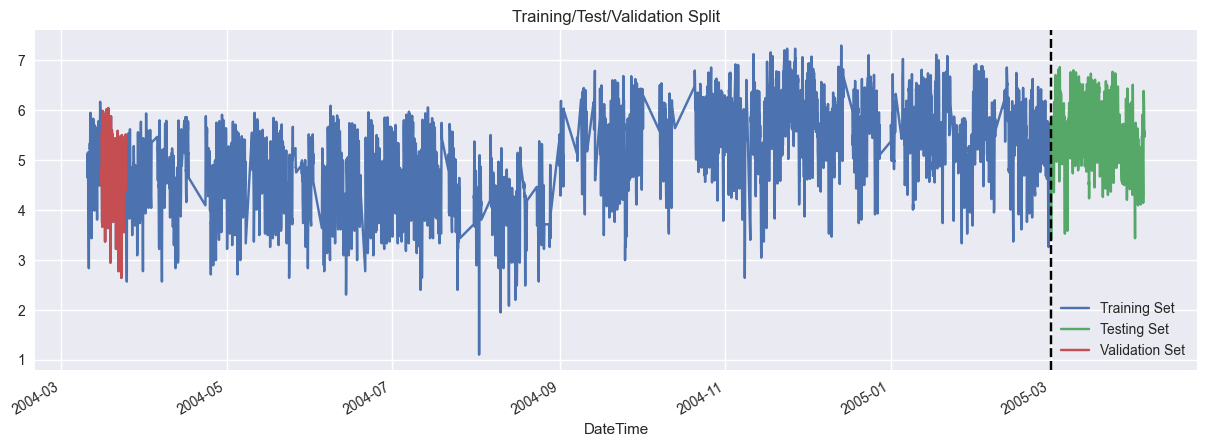

In [82]:
# https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

train = dataset.loc[dataset.index < '2005-03-01']
test = dataset.loc[dataset.index >= '2005-03-01']

def create_time_series_split(data, target, time=1):
    data_time = data.copy()
    for i in range(1, time + 1):
        data_time[f'{target}_time_{i}'] = data[target].shift(i)
    data_time.dropna(inplace=True)
    x = data_time.drop(target, axis=1)
    y = data_time[target]
    return x, y

X_train, y_train = create_time_series_split(train, 'NOx(GT)', 12)
X_test, y_test = create_time_series_split(test, 'NOx(GT)', 12)

truth_val = y_train.iloc[100:301].copy()
truth_train = pd.concat([y_train.iloc[0:100], y_train.iloc[301:]])
truth_test = y_test.copy()

print(truth_train.shape)
print(truth_val.shape)


print(X_train.info)
print(X_train.shape)
print(X_test.shape)


fig, ax = plt.subplots(figsize = (15, 5))
train['NOx(GT)'].plot(ax=ax, label="Training Set", title='Training/Test/Validation Split')
test['NOx(GT)'].plot(ax=ax, label="Testing Set")
truth_val.plot(ax=ax, label="Validation Set")
plt.legend(loc = 'lower right')
ax.axvline('2005-03-01', color = 'black', ls='--')
plt.show()

# Standardization/Normalization

In [63]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(Xtrain)
Xtrain = norm.transform(Xtrain)
Xtest = norm.transform(Xtest)

norm = MinMaxScaler().fit(X_train)
X_train = norm.transform(X_train)
X_test = norm.transform(X_test)

In [64]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler().fit(Xtrain)
Xtrain = scale.transform(Xtrain)
Xtest = scale.transform(Xtest)


scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [65]:
print(ytrain.describe())

count    5552.000000
mean        5.196786
std         0.864145
min         1.098612
25%         4.634729
50%         5.231109
75%         5.823046
max         7.299797
Name: NOx(GT), dtype: float64


# Linear Regression

In [66]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score

model = LinearRegression(fit_intercept=True)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print(ytest[:10])
print(ytest.shape)
print(ypred[:10])
print(ypred.shape)

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print('R2 metric:', r2_score(ytest, ypred))


DateTime
2004-11-25 16:00:00    6.144186
2005-03-26 07:00:00    5.170484
2005-03-28 19:00:00    6.232448
2005-03-20 18:00:00    5.484797
2005-03-19 18:00:00    5.587249
2005-03-21 00:00:00    5.214936
2004-03-15 10:00:00    5.978886
2004-07-10 01:00:00    4.521789
2004-12-06 01:00:00    4.836282
2004-10-09 04:00:00    4.574711
Name: NOx(GT), dtype: float64
(1389,)
[6.12583244 4.90290207 5.57051637 5.49294689 5.53900817 5.19901319
 5.05954278 4.17998791 5.27883046 4.71540166]
(1389,)
Root Mean Squared Error: 0.6050882574113574
R2 metric: 0.450161270702198


# Support Vector Machine

In [67]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=100).fit(X, y)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print('R2 metric:', r2_score(ytest, ypred))


Root Mean Squared Error: 0.28047968944282686
R2 metric: 0.8818589808081241


# K-Neighbours Regressor

In [68]:
# Not used in Report
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print('R2 metric:', r2_score(ytest, ypred))


Root Mean Squared Error: 0.39871257656000053
R2 metric: 0.7612640912765264


# Neural Network: dropout, early stopping

In [69]:
# Regression
print(Xtrain.shape)
print(Xtest.shape)

(5552, 12)
(1389, 12)


In [75]:
# Time-Series

Xval = X_train[100:301]
yval = y_train[100:301]
print
print(Xval.shape)
print(X_train.shape)


X_train = np.delete(X_train, range(100, 301), axis = 0)
y_train = np.delete(y_train, range(100, 301), axis = 0)
print(X_train.shape)


Xtrain=np.asarray(X_train).reshape(X_train.shape[0],1, X_train.shape[1])
ytrain=np.asarray(y_train).reshape(y_train.shape[0], 1,-1)

Xval=np.asarray(Xval).reshape(Xval.shape[0], 1, Xval.shape[1])
yval=np.asarray(yval).reshape(yval.shape[0], 1, -1)

Xtest=np.asarray(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])
ytest=np.asarray(y_test).reshape(y_test.shape[0], 1, -1)

print(Xval.shape)
print(Xtrain.shape)
print(Xtest.shape)

(201, 24)
(6132, 24)
(5931, 24)
(201, 1, 24)
(5931, 1, 24)
(785, 1, 24)


In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input

model = Sequential()
model.add(Input(shape=Xtrain.shape[1]))
model.add(Dense(1024,activation='relu')) #Hidden 2
model.add(Dropout(0.2))

model.add(Dense(512,activation='relu')) #Hidden 4
model.add(Dropout(0.2))

model.add(Dense(256,activation='relu')) #Hidden 5
model.add(Dropout(0.2))

model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.001))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
model.summary()

training_trace = model.fit(Xtrain, ytrain,verbose=2, validation_split=0.10, callbacks=[monitor], epochs=250)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1024)              13312     
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                

In [76]:
model = Sequential()
model.add(Input(shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(LSTM(128))
model.add(Dense(1024,activation='relu')) #Hidden 2
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu')) #Hidden 3
model.add(Dropout(0.2))
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.0001))
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')
model.summary()

training_trace = model.fit(Xtrain, ytrain,verbose=2, validation_data=(Xval, yval), callbacks=[monitor], epochs=200)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               78336     
                                                                 
 dense_24 (Dense)            (None, 1024)              132096    
                                                                 
 dropout_18 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1,261,057
Trainable params: 1,261,057
No

# Evaluation and Loss plot

(1389, 12)
(1389, 12)
(1389, 1)
(1389,)
Root Mean Squared Error: 0.30279620340848606
R2 metric: 0.8623111640399235


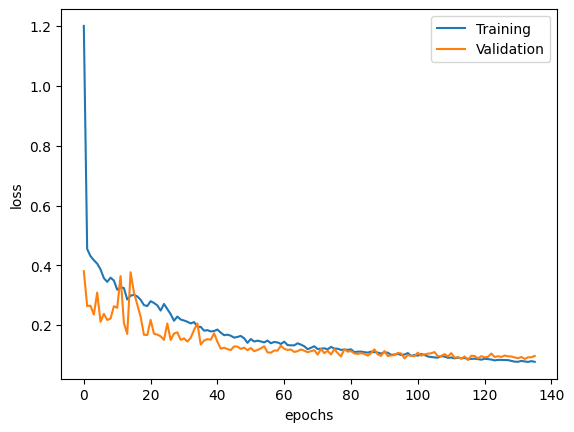

In [71]:
# Plots showcased here are from the neural network
print(Xtest.shape)
ypred = model.predict(Xtest)
# Time Series
# Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[2])
# ytest = ytest.reshape(ytest.shape[0], ytest.shape[2])

print(Xtest.shape)
print(ypred.shape)
print(ytest.shape)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ytest, ypred)))
print('R2 metric:', r2_score(ytest, ypred))

# Plot validation, training loss
plt.plot(training_trace.history['loss'], label = 'Training')
plt.plot(training_trace.history['val_loss'], label = 'Validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

# Truth and Predictions side by side

In [72]:
print(Xtest.shape)
# Time Series
# ypred = ypred.flatten()
# ytest = ytest.flatten()
print(ypred.shape)
print(ytest.shape)
dataset_comparison = pd.DataFrame({'Actual': ytest, 'Predicted': ypred.flatten()})
dataset_head = dataset_comparison.head(40)
print(dataset_head)

(1389, 12)
(1389, 1)
(1389,)
                       Actual  Predicted
DateTime                                
2004-11-25 16:00:00  6.144186   6.093141
2005-03-26 07:00:00  5.170484   5.381386
2005-03-28 19:00:00  6.232448   5.653513
2005-03-20 18:00:00  5.484797   5.328681
2005-03-19 18:00:00  5.587249   5.560096
2005-03-21 00:00:00  5.214936   5.276745
2004-03-15 10:00:00  5.978886   5.809387
2004-07-10 01:00:00  4.521789   4.579249
2004-12-06 01:00:00  4.836282   5.136508
2004-10-09 04:00:00  4.574711   4.724051
2004-09-25 18:00:00  5.187386   4.995896
2005-03-30 09:00:00  6.120297   5.773305
2004-07-16 21:00:00  5.283204   5.132787
2004-06-23 18:00:00  5.529429   5.210357
2004-05-14 22:00:00  4.934474   4.743693
2004-08-02 14:00:00  4.304065   4.276768
2004-11-02 13:00:00  6.369901   6.260346
2004-08-14 16:00:00  3.610918   3.643931
2004-08-24 22:00:00  4.584967   4.351858
2004-11-08 14:00:00  5.509388   5.368312
2005-02-06 22:00:00  5.068904   5.240434
2005-02-21 09:00:00  5.87493

# Chart Regression

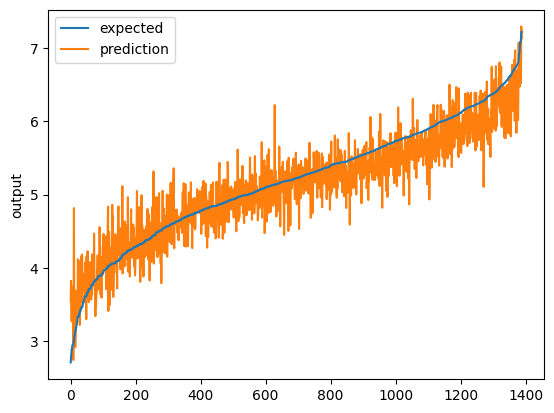

In [73]:
# From previous labs
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected', zorder=3)
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
chart_regression(ypred.flatten(),ytest,sort=True) 

# Grid Regression

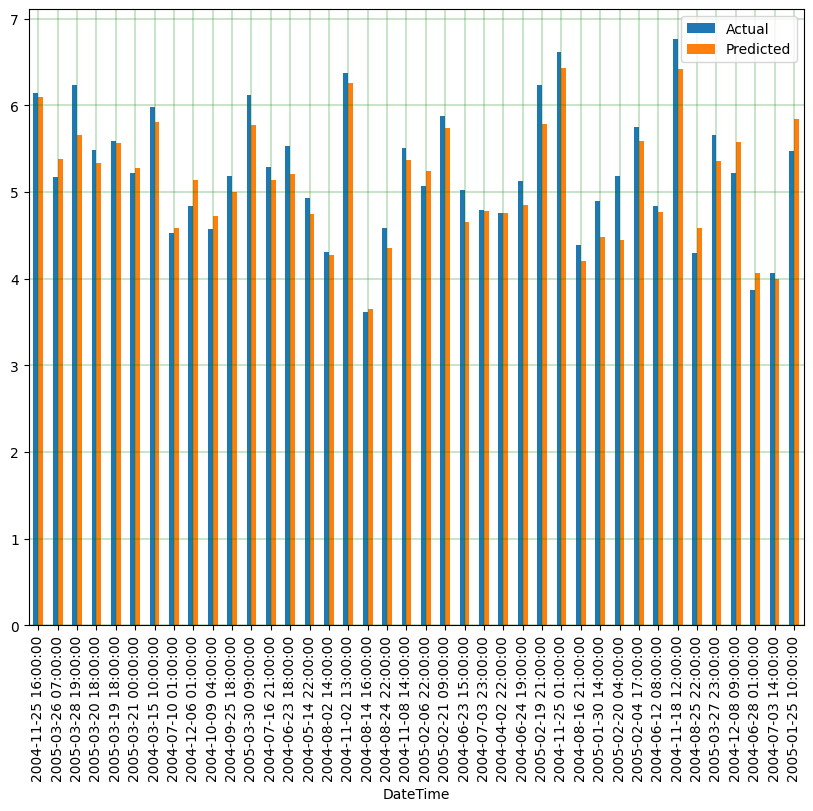

Mean: 5.195640208256409


In [74]:
# From previous labs
dataset_head.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.show()

print('Mean:', np.mean(ytest))

# Time Series Plot

In [77]:
Xtest=np.asarray(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

trainPredict = model.predict(Xtrain)
valPredict = model.predict(Xval)
testPredict = model.predict(Xtest)

trainPredict = trainPredict.flatten()
testPredict = testPredict.flatten()

print(trainPredict.shape)
print(y_train.shape)

(5931,)
(5931,)


In [78]:
trainPredict = pd.DataFrame(trainPredict ,index=truth_train.index)
testPredict = pd.DataFrame(testPredict ,index=truth_test.index)
valPredict = pd.DataFrame(valPredict ,index=truth_val.index)

print(trainPredict.shape)
print(truth_train.shape)

print(testPredict.shape)
print(truth_test.shape)

print(valPredict.shape)
print(truth_val.shape)

(5931, 1)
(5931,)
(785, 1)
(785,)
(201, 1)
(201,)


In [79]:
print (plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


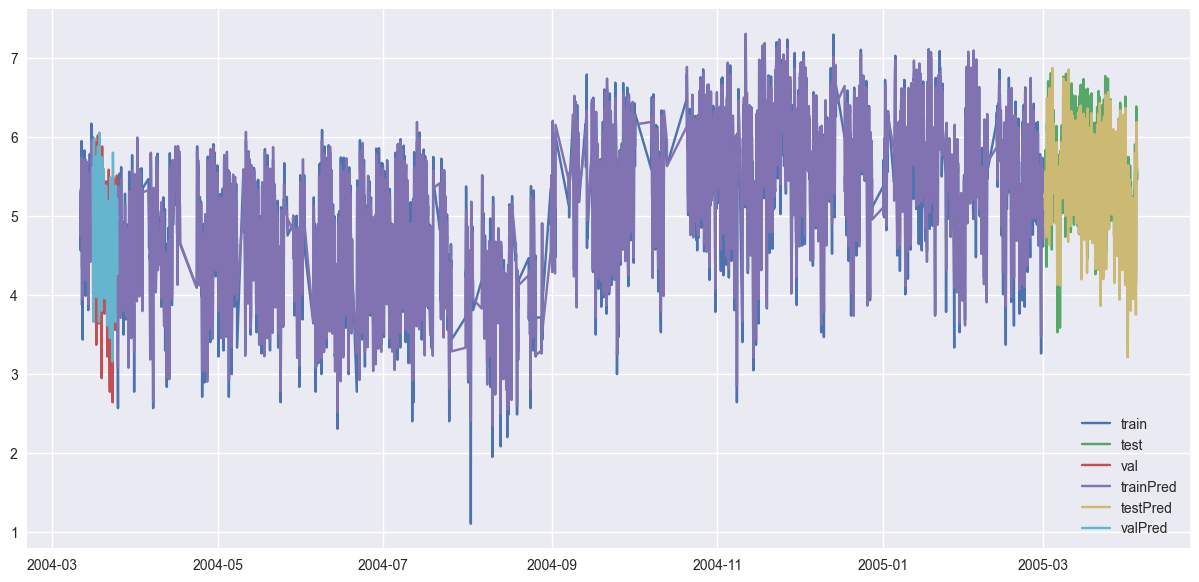

In [81]:
# plot truth and predictions
plt.subplots(figsize = (15, 7))
plt.plot(truth_train, label = 'train')
plt.plot(truth_test, label = 'test')
plt.plot(truth_val, label = 'val')
plt.plot(trainPredict, label = 'trainPred')
plt.plot(testPredict, label = 'testPred')
plt.plot(valPredict, label = 'valPred')

plt.style.use('seaborn-v0_8')
plt.legend(loc = 'lower right')

plt.show()